In [1]:
%load_ext autotime

time: 252 µs (started: 2022-01-24 12:20:51 +01:00)


In [2]:
import pytorch_lightning as pl
from torch.nn import functional as F
from torch import nn
import torch

time: 1.03 s (started: 2022-01-24 12:20:51 +01:00)


In [3]:
import numpy as np

import glob

training_data_files = glob.glob("/home/aaron/projects/ghost/data/spike_in/chromatograms/*.npz")

time: 1.65 ms (started: 2022-01-24 12:20:53 +01:00)


In [4]:
chrom_tensors = []
label_tensors = []
score_tensors = []

for training_data_file in training_data_files:

    chrom_training_data_file = np.load(training_data_file)

    chrom_tensors.append(
        torch.from_numpy(chrom_training_data_file["chromatograms"]).type(torch.FloatTensor)
    )
    label_tensors.append(
        torch.from_numpy(chrom_training_data_file["labels"]).type(torch.FloatTensor)
    )

    score_tensors.append(
        torch.from_numpy(chrom_training_data_file["scores"]).type(torch.FloatTensor)
    )

chrom_tensors = torch.cat(chrom_tensors, 0)
label_tensors = torch.cat(label_tensors, 0)
score_tensors = torch.cat(score_tensors, 0)

time: 139 ms (started: 2022-01-24 12:20:53 +01:00)


In [5]:
chrom_tensors.shape, label_tensors.shape, score_tensors.shape

(torch.Size([107692, 1, 6, 25]),
 torch.Size([107692, 1]),
 torch.Size([107692, 1]))

time: 6.43 ms (started: 2022-01-24 12:20:54 +01:00)


In [6]:
conv_layer = nn.Sequential(
    nn.Conv2d(
        in_channels=1,
        out_channels=10,
        kernel_size=5,
        padding="same",
    ), nn.ReLU(),
    nn.MaxPool2d(
        kernel_size=2,
        stride=1
    ),
    nn.Conv2d(
        10, 10,
        kernel_size=5,
        padding="same",
    ), nn.ReLU(),
    nn.MaxPool2d(
        kernel_size=2,
        stride=2
    ),
    nn.Flatten()
)


time: 2.02 ms (started: 2022-01-24 12:20:54 +01:00)


In [7]:
out = conv_layer(chrom_tensors[0].reshape(1, 1, 6, 25))
out.shape

torch.Size([1, 240])

time: 2.6 ms (started: 2022-01-24 12:20:55 +01:00)


In [8]:
from torch.utils.data import TensorDataset, DataLoader

time: 269 µs (started: 2022-01-24 12:20:55 +01:00)


In [9]:
chrom_dataset = TensorDataset(chrom_tensors, label_tensors)

time: 315 µs (started: 2022-01-24 12:20:55 +01:00)


In [10]:
train_length = int(0.7* len(chrom_dataset))

test_length = len(chrom_dataset) - train_length

train_dataset, test_dataset = torch.utils.data.random_split(
    chrom_dataset,
    (train_length, test_length)
)

time: 5.63 ms (started: 2022-01-24 12:20:55 +01:00)


In [11]:
validation_length = int(0.1 * len(train_dataset))
validation_length

7538

time: 1.94 ms (started: 2022-01-24 12:20:56 +01:00)


In [12]:
train_length = len(train_dataset) - validation_length
train_length

67846

time: 1.7 ms (started: 2022-01-24 12:20:56 +01:00)


In [13]:
train_dataset, validation_dataset = torch.utils.data.random_split(
    train_dataset,
    (train_length, validation_length)
)

time: 3.52 ms (started: 2022-01-24 12:20:57 +01:00)


In [14]:
chrom_dataloader = DataLoader(
    train_dataset,
    batch_size=100,
    shuffle=True,
    num_workers=10
)

time: 624 µs (started: 2022-01-24 12:20:57 +01:00)


In [15]:
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=100,
    num_workers=10
)

time: 501 µs (started: 2022-01-24 12:20:57 +01:00)


In [16]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=100,
    num_workers=10
)

time: 367 µs (started: 2022-01-24 12:20:58 +01:00)


In [31]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


class DeepChromModel(pl.LightningModule):

    def __init__(self, learning_rate=0.0005):

        self.lr = learning_rate

        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=10,
                kernel_size=5,
                padding="same",
            ), nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=1
            ),
            nn.Conv2d(
                10, 10,
                kernel_size=5,
                padding="same",
            ), nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),
            nn.Flatten()
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(240, 240), nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(240, 240), nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(240, 1)
        )

    def configure_optimizers(self):

        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=(self.lr or self.learning_rate)
        )

        scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=5, min_lr=1e-6)

        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "train_loss"
        }

    def training_step(self, batch, batch_idx):

        chromatograms, labels = batch

        y_hat = self(chromatograms)

        loss = F.binary_cross_entropy_with_logits(
            y_hat,
            labels
        )

        self.log(
            "train_loss",
            loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )

        return loss

    def validation_step(self, batch, batch_idx):

        chromatograms, labels = batch

        y_hat = self(chromatograms)

        loss = F.binary_cross_entropy_with_logits(
            y_hat,
            labels
        )

        return loss

    def test_step(self, batch, batch_idx):

        chromatograms, labels = batch

        y_hat = self(chromatograms)

        loss = F.binary_cross_entropy_with_logits(
            y_hat,
            labels
        )

        labels_hat = torch.argmax(y_hat, dim=1)

        accuracy = torch.sum(labels_hat == labels).item() / (len(labels) * 1.0)

        self.log_dict({
            'test_loss': loss,
            'test_acc': accuracy,
        })

    def predict_step(self, batch, batch_idx, dataloader_idx=0):

        chromatograms, = batch

        return self(chromatograms)

    def forward(self, chromatogram):

        out = self.conv_layers(chromatogram)

        out = self.linear_layers(out)

        return out

time: 1.49 ms (started: 2022-01-24 12:30:47 +01:00)


In [27]:
model = DeepChromModel()

time: 2.45 ms (started: 2022-01-24 12:29:02 +01:00)


In [28]:
trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    auto_lr_find=True
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


time: 3.94 ms (started: 2022-01-24 12:29:02 +01:00)


In [29]:
trainer.tune(
    model,
    train_dataloaders=chrom_dataloader
)

/home/aaron/miniconda3/envs/ghostdev/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:118: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /home/aaron/projects/gscorer/gscore/notebooks/lr_find_temp_model_016b28a4-ecac-4e76-aa7b-c6babc5800ac.ckpt
Learning rate set to 0.04365158322401657


{'lr_find': <pytorch_lightning.tuner.lr_finder._LRFinder at 0x7fcc04b1a160>}

time: 1.04 s (started: 2022-01-24 12:29:03 +01:00)


In [30]:
trainer.fit(
    model,
    train_dataloaders=chrom_dataloader,
    val_dataloaders=validation_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | conv_layers   | Sequential | 2.8 K 
1 | linear_layers | Sequential | 115 K 
---------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.475     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

time: 1min 37s (started: 2022-01-24 12:29:07 +01:00)


/home/aaron/miniconda3/envs/ghostdev/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [23]:
trainer.test(ckpt_path="best", dataloaders=test_dataloader)

Restoring states from the checkpoint path at /home/aaron/projects/gscorer/gscore/notebooks/lightning_logs/version_49/checkpoints/epoch=9-step=6789.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/aaron/projects/gscorer/gscore/notebooks/lightning_logs/version_49/checkpoints/epoch=9-step=6789.ckpt


Testing: 0it [00:00, ?it/s]

Exception ignored in: <function _releaseLock at 0x7f7d675cf430>
Traceback (most recent call last):
  File "/home/aaron/miniconda3/envs/ghostdev/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


time: 1.02 s (started: 2022-01-24 11:58:13 +01:00)


In [52]:
label_tensors[3], score_tensors[3]

(tensor([1.]), tensor([0.8234]))

time: 5 ms (started: 2022-01-24 11:44:42 +01:00)


In [53]:
trainer.save_checkpoint(
    "test.model"
)

time: 7.69 ms (started: 2022-01-24 11:44:43 +01:00)


In [54]:
model = DeepChromModel.load_from_checkpoint(
    checkpoint_path="test.model"
)

time: 6.54 ms (started: 2022-01-24 11:44:46 +01:00)


In [55]:
trainer = pl.Trainer(gpus=1)

pred_dataset = TensorDataset(
    chrom_tensors
)

pred_dataloader = DataLoader(
    pred_dataset,
    num_workers=10,
    batch_size=10000

)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


time: 3.24 ms (started: 2022-01-24 11:44:48 +01:00)


In [56]:
predictions = trainer.predict(
    model,
    dataloaders=pred_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/home/aaron/miniconda3/envs/ghostdev/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:172: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


time: 888 ms (started: 2022-01-24 11:44:49 +01:00)


In [57]:
predictions = torch.cat(predictions, 0).numpy()

time: 967 µs (started: 2022-01-24 11:44:51 +01:00)


In [58]:
import seaborn as sns
import pandas as pd

time: 251 ms (started: 2022-01-24 11:44:53 +01:00)


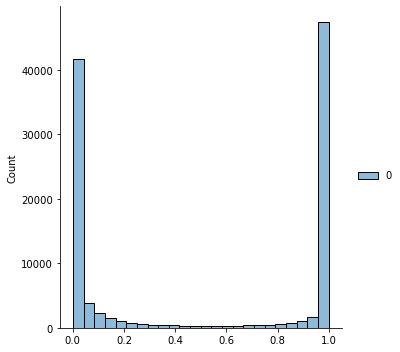

time: 260 ms (started: 2022-01-24 11:44:53 +01:00)


In [59]:
sns.displot(predictions)

In [72]:
predictions.shape

(107692, 1)

time: 1.27 ms (started: 2022-01-24 11:49:29 +01:00)


In [81]:
score_comparisons = pd.DataFrame(
    {
        "label": label_tensors.numpy().reshape(-1),
        "de_noising_score": score_tensors.numpy().reshape(-1),
        "prediction": predictions.reshape(-1)
    }
)

time: 1.37 ms (started: 2022-01-24 11:55:19 +01:00)


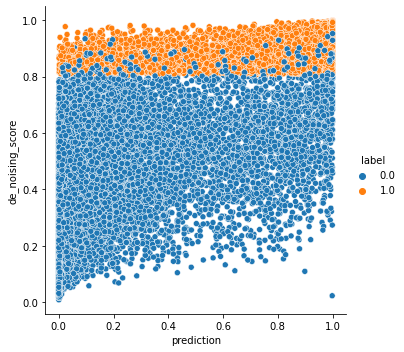

time: 4.14 s (started: 2022-01-24 11:55:19 +01:00)


In [82]:
sns.relplot(data=score_comparisons, x="prediction", y="de_noising_score", hue="label")

In [66]:
predictions[-1], label_tensors[-1], score_tensors[-1]

(array([0.02516307], dtype=float32), tensor([0.]), tensor([0.5909]))

time: 2.21 ms (started: 2022-01-24 11:46:07 +01:00)


In [68]:
test = pd.DataFrame(
    chrom_tensors[0].T.numpy()
)

In [69]:
test

,0,1,2,3,4,5,6
0,38.809586,0.000000,1.780750,0.000000,0.000000,0.00000,0.000000
1,38.859440,5.485782,1.749358,0.000000,0.000000,0.00000,0.000000
2,38.907871,5.000940,1.442997,0.000000,0.000000,0.00000,0.000000
3,38.956299,4.351316,1.259673,0.000000,0.000000,0.00000,0.000000
4,39.006153,1.788122,0.000000,0.000000,0.000000,1.24479,0.328399
...,...,...,...,...,...,...,...
170,47.146622,0.879885,1.132586,0.147499,0.633377,0.00000,0.306697
171,47.196476,1.801184,1.841516,0.256664,1.230467,0.00000,0.000000
172,47.244904,0.876688,0.425028,0.000000,0.000000,0.00000,0.000000
173,47.294758,1.075987,0.808249,0.206082,1.506182,0.00000,0.000000


In [70]:
melted_test = test.melt(id_vars=[0])
melted_test[melted_test[0] > 0]

,0,variable,value
0,38.809586,1,0.000000
1,38.859440,1,5.485782
2,38.907871,1,5.000940
3,38.956299,1,4.351316
4,39.006153,1,1.788122
...,...,...,...
1044,47.098190,6,0.268802
1045,47.146622,6,0.306697
1046,47.196476,6,0.000000
1047,47.244904,6,0.000000


In [71]:
peakgroup_boundary_tensors[0][0]

tensor(42.8810)

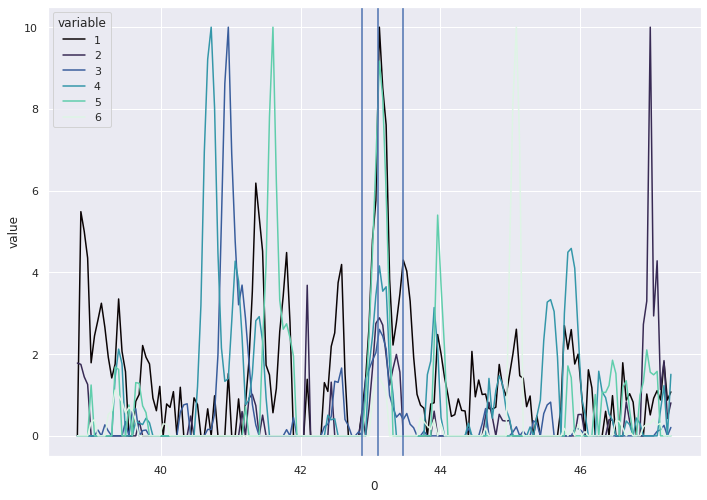

In [72]:
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=melted_test[melted_test[0] > 0], x=0, y="value", hue="variable", palette="mako")
plt.axvline(peakgroup_boundary_tensors[0][0])
plt.axvline(peakgroup_boundary_tensors[0][1])
plt.axvline(peakgroup_boundary_tensors[0][2])